In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [5]:
(img_h, img_w) = (160, 160)

In [6]:
def loadImages(path, label):
    arr = np.ndarray([1,img_h, img_w ,3])
    imagesList = listdir(path)
    for image in imagesList:
        img = Image.open(path + image)
        img = np.asarray(img)
        img = cv2.resize(img, (img_h, img_w), interpolation=cv2.INTER_CUBIC)
        img = np.expand_dims(img, axis=0)
        arr = np.append(arr, img, axis = 0)
    arr = arr[1::] 
    return arr

In [14]:
def arrayToDataset(label, data):
    
    # Split into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=33)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=33)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    return train_dataset, val_dataset, test_dataset

In [8]:
labels = np.array([listdir('./boats')[0::]])

In [9]:
labels_map = {'buoy':0,
              'cruise ship':1,
              'ferry boat':2,
              'freight boat':3,
              'gondola':4,
              'inflatable boat':5,
              'kayak':6,
              'paper boat':7,
              'sailboat':8}

In [10]:
data_images = {}
data_labels = {}
for label in labels[0]:
    path = './boats/{}/'.format(label)
    data_images["images_%s" %label] = loadImages(path, label)
    data_labels["label_%s" %label] = np.array([labels_map['%s' %label] 
                                               for x in 
                                           range(data_images["images_%s" %label].shape[0])])
    data_labels["label_%s" %label] = np.expand_dims(data_labels["label_%s" %label],
                                                    axis=1)
    

In [12]:
label = np.concatenate(list(data_labels["label_%s" %label] for label in labels[0])
                        , axis=0)

In [13]:
data = np.concatenate(list(data_images["images_%s" %label] for label in labels[0]),
                      axis=0)

In [15]:
train_dataset, val_dataset, test_dataset = arrayToDataset(label, data)

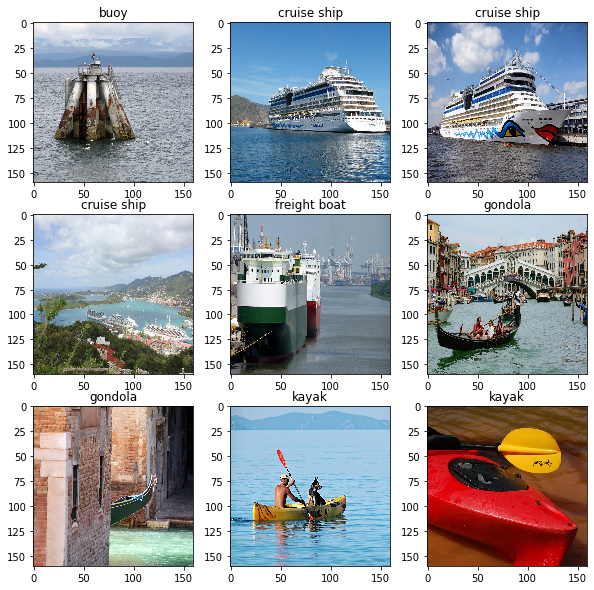

In [50]:
labels_map_vers = {0:'buoy', 1:'cruise ship', 2:'ferry boat', 3:'freight boat', 4:'gondola',
       5:'inflatable boat', 6:'kayak', 7:'paper boat', 8:'sailboat'}
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i*100].astype("uint8"))
    plt.title(labels_map_vers[int(label[i*100])])

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [19]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [21]:
prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.001
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [29]:
len(model.trainable_variables)

2

In [30]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(test_dataset)

5/5 [==============================] - 5s 401ms/step - loss: 2.5446 - accuracy: 0.0943


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/15
37/37 [==============================] - 29s 611ms/step - loss: 1.8327 - accuracy: 0.4135 - val_loss: 1.2111 - val_accuracy: 0.6301
Epoch 2/15
37/37 [==============================] - 20s 545ms/step - loss: 1.1122 - accuracy: 0.6404 - val_loss: 0.9320 - val_accuracy: 0.7329
Epoch 3/15
37/37 [==============================] - 22s 594ms/step - loss: 0.9563 - accuracy: 0.6721 - val_loss: 0.7461 - val_accuracy: 0.7808
Epoch 4/15
37/37 [==============================] - 21s 561ms/step - loss: 0.8492 - accuracy: 0.7209 - val_loss: 0.6917 - val_accuracy: 0.7877
Epoch 5/15
37/37 [==============================] - 20s 535ms/step - loss: 0.7621 - accuracy: 0.7457 - val_loss: 0.6469 - val_accuracy: 0.7877
Epoch 6/15
37/37 [==============================] - 20s 527ms/step - loss: 0.7012 - accuracy: 0.7628 - val_loss: 0.6283 - val_accuracy: 0.7877
Epoch 7/15
37/37 [==============================] - 18s 488ms/step - loss: 0.6701 - accuracy: 0.7791 - val_loss: 0.6135 - val_accuracy: 0.8151

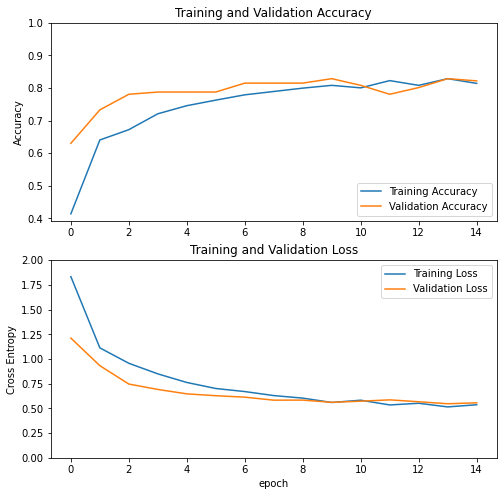

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)

5/5 [==============================] - 2s 397ms/step - loss: 0.6376 - accuracy: 0.8014


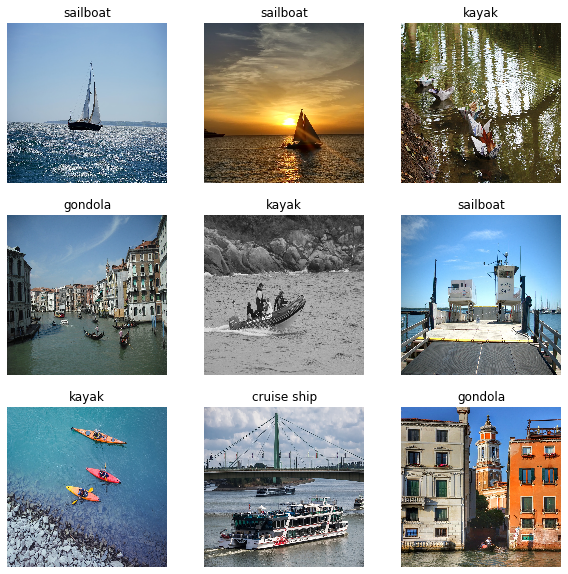

In [76]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(labels_map_vers[np.argmax(predictions[i])])
  plt.axis("off")